# Face Detection and Recognition CNN Models

Author: Luca Franceschi (u199149)

In this notebook we will try to construct two CNN models, one for face boundary detection and another for face recognition. The intention for the Coding Challenge 3 is to: with each image first detect if there is a face or not, in case there is, detect the boundaries. Then we can crop the image with the calculated boundaries and pass it to the recognition model to be able to recognize if the face exists in the dataset or is an impostor.

In [109]:
import torch
import scipy.io
import torch.jit
import numpy as np
from torch import nn
from PIL import Image
import torch.optim as optim
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import random_split
from torchvision.transforms.functional import get_image_size

In [110]:
# Hyperparameters
lr = 0.001                  # Learning rate
epochs = 101                # Total number of epochs
batch_size = 32             # The sizes in which the dataset is split to feed the networks
resized = (224, 224)        # The normalized size of the images

# Other parameters
epoch_step = 5              # Frequency in which epoch losses are printed on training
images_path = './TRAINING/' # Relative path to the training dataset
target_matrix_path = ''     # Relative path to the "AGC_Challenge3_Training.mat" file

In [111]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Loading the target matrix

When loading the matrix we can import either the boundaries or the identity. 
- For the detection network we will import the Image name along with the boundaries. In case there is a face (or more) the first position in the boundaries will be the amount of faces in that image. In case there is no faces, that parameter will be 0 and the boundaries will be a "padding" of zeros. The imported data in this case will look like: ```[name, [#faces, x0, y0, x1, y1]]```, very similar as in previous labs. In case there are more than one face the first one in the matrix will be considered.
- For the recognition network... <font color="red">TODO</font>

In [112]:
def load_data(labels_path, labels_wanted='boundaries'):
    mat = scipy.io.loadmat(labels_path)['AGC_Challenge3_TRAINING'][0]
    data = []
    for entry in mat:
        key = entry[1][0]
        if (labels_wanted == 'boundaries'):
            if (len(entry[2]) > 0):
                # tmp = [len(entry[2])]
                # tmp.extend(entry[2][0])
                # label = np.array(tmp, dtype=np.int32)
                label = np.array(entry[2][0], dtype=np.int32)
            # else:
            #     label = np.zeros(5, dtype=np.int32)
                data.append([key, label])

        elif (labels_wanted == 'identity'):
            data.append([key, entry[0][0][0]])
    return data

## The transforms

In [113]:
# mean and std extracted from the train_dataset part of AGC_Challenge3_TRAINING
# def compute_mean_std(dataset):
#     all_pixels = []
#     for image_path, _ in dataset:
#         with Image.open(images_path + image_path) as image:
#             image_array = np.array(image)
#             all_pixels.append(image_array)

#     all_images = np.stack(all_pixels, axis=0)

#     mean = np.mean(all_images, axis=(0, 1, 2)) / 255.0
#     std_dev = np.std(all_images, axis=(0, 1, 2)) / 255.0

#     return mean, std_dev

In [114]:
det_tr_transform = transforms.Compose([
    # transforms.Resize(300, 300),
    transforms.RandomResizedCrop(resized),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=train_mean, std=train_std)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

base_transform = transforms.Compose([
    transforms.Resize(resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## The Detection Model

### The dataset

In [115]:
class DetectionData(Dataset):
    # the data is in the form [img_name, boundaries] or [img_name, identity]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        with Image.open(images_path + image_name) as image:
            # Apply transformations if specified
            image = image.convert('RGB')
            w, h = get_image_size(image)
            if self.transform:
                image = self.transform(image)
            # image = torch.tensor(image, dtype=torch.float32)

            # label = [label[0], label[1]/w*resized[0], label[2]/h*resized[1], label[3]/w*resized[0], label[4]/h*resized[1]]
            label = [label[0]/w*resized[0], label[1]/h*resized[1], label[2]/w*resized[0], label[3]/h*resized[1]]
            label = torch.tensor(label, dtype=torch.float32)
            label = torch.flatten(label)
            return image, label

In [116]:
# transforms son copiados, revisar
# calcular valores de mean y std del dataset para cada channel
# o las de imagenet
# flipping, cambios de colores, grayscale
# contraste de saturacion 
# color spaces
################

all_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat')
train_data, val_data, test_data = random_split(all_data, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(42))

# train_mean, train_std = compute_mean_std(train_data)

train_dataset = DetectionData(train_data, det_tr_transform)
val_dataset = DetectionData(val_data, base_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### The Network

In [117]:
class DetectionCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(25088, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 4)
        )

    def forward(self, data):
        x = self.cnn_layers(data)
        x = self.flatten(x) # before linear layer !!!
        x = self.fc_layers(x)
        return x

    def fit(self, training_data, loss_fn, optimizer: optim.Optimizer): # cross entropy con softmax + adam
        self.train()
        total_loss = 0.0

        for batch_data, target in training_data:
            batch_data = batch_data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = self.forward(batch_data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(training_data)

        # for e in range(epochs):
        #     epoch_loss = 0

        #     if e % epoch_step == 0:
        #         print(f'Epoch {e} has loss {epoch_loss / batch_size}')

    def evaluate(self, validation_data, loss_fn): # unused by now
        self.eval()
        total_loss = 0.0

        for batch_data, target in validation_data:
            batch_data = batch_data.to(device)
            target = target.to(device)
            
            output = self.forward(batch_data)
            loss = loss_fn(output, target)

            total_loss += loss.item()

            # Compute accuracy
            # _, predicted = torch.max(output, 1)
            # total_predictions += labels.size(0)
            # correct_predictions += (predicted == labels).sum().item()

        # average_loss = total_loss / len(validation_data)
        # accuracy = correct_predictions / total_predictions

        return total_loss / len(validation_data)

    def predict(self, test_image):
        self.eval()
        with torch.inference_mode(mode=True):
            test_image = test_image.convert('RGB')
            w, h = get_image_size(test_image)
            test_image = base_transform(test_image)
            # test_image = torch.tensor(test_image, dtype=torch.float32)
            output = self.forward(test_image.unsqueeze(0))[0]
            # print(output)
            # output = [output[0], output[1]*w/resized[0], output[2]*h/resized[1], output[3]*w/resized[0], output[4]*h/resized[1]]
            output = [output[0]*w/resized[0], output[1]*h/resized[1], output[2]*w/resized[0], output[3]*h/resized[1]]
            print(output)
            return output

In [118]:
detection = DetectionCNNModel().to(device)
print(detection)

DetectionCNNModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=25088, out_features=16

In [119]:
pytorch_total_params = sum(p.numel() for p in detection.parameters())
print(pytorch_total_params)

407636


### The Training Loop

In [120]:
# train loop as train and then test
loss = nn.MSELoss()
optimizer = optim.Adam(detection.parameters(), lr=lr)

tr_losses = []
val_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    tr_losses.append(detection.fit(train_loader, loss, optimizer))
    val_losses.append(detection.evaluate(val_loader, loss))

    if epoch % epoch_step == 0:
        print(f'Epoch {epoch} has loss {val_losses[epoch]}')

Epoch 0 has loss 5671.892822265625
Epoch 5 has loss 640.5383911132812
Epoch 10 has loss 595.0657043457031
Epoch 15 has loss 561.2248382568359
Epoch 20 has loss 629.9383544921875
Epoch 25 has loss 611.1501770019531
Epoch 30 has loss 540.3395690917969
Epoch 35 has loss 527.9709777832031
Epoch 40 has loss 536.7732086181641
Epoch 45 has loss 549.0616149902344
Epoch 50 has loss 518.6077728271484
Epoch 55 has loss 532.8100738525391
Epoch 60 has loss 559.4945831298828
Epoch 65 has loss 538.8428039550781
Epoch 70 has loss 525.1230773925781
Epoch 75 has loss 522.0219268798828
Epoch 80 has loss 572.7717437744141
Epoch 85 has loss 539.5976867675781
Epoch 90 has loss 529.4815979003906
Epoch 95 has loss 536.8411865234375
Epoch 100 has loss 527.0800018310547


### Plots

In [121]:
def loss_epoch_plot(losses, title='Loss vs training epochs', nbins='auto'):
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins, integer=True))
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    x = np.linspace(1, len(losses)+1, len(losses), dtype=np.uint16)
    plt.plot(x, losses)
    
    plt.show()

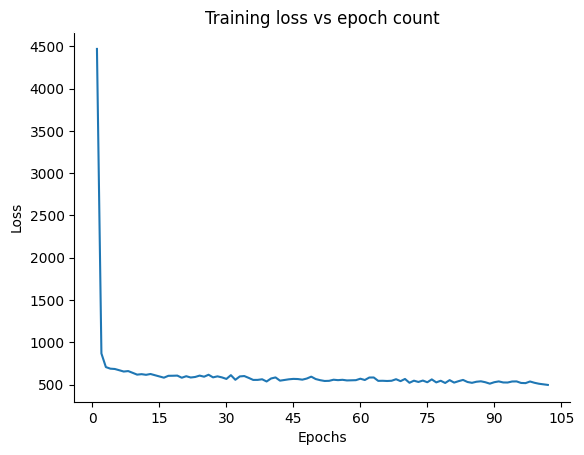

In [130]:
loss_epoch_plot(tr_losses, "Training loss vs epoch count")

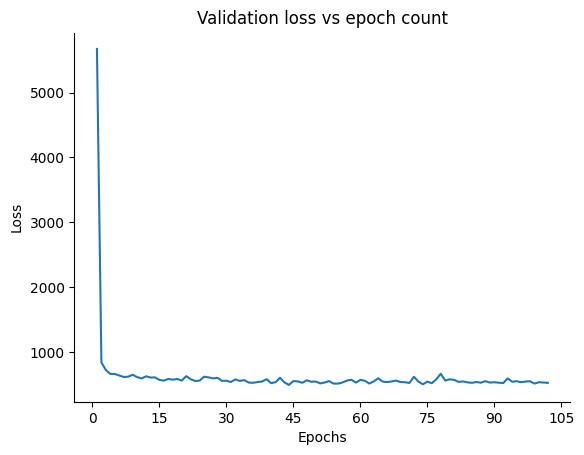

In [131]:
loss_epoch_plot(val_losses, "Validation loss vs epoch count")

In [124]:
with Image.open(images_path + 'image_A0003.jpg') as image:
    detection.predict(image)

[tensor(148.4670), tensor(54.6154), tensor(431.0132), tensor(191.9019)]


### Testing

[ 42 208 430 596]
[tensor(117.6543), tensor(179.8751), tensor(395.1179), tensor(545.2982)]


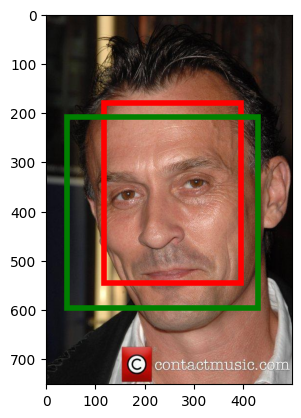

[153  65 339 251]
[tensor(137.7519), tensor(152.6320), tensor(341.2894), tensor(430.1245)]


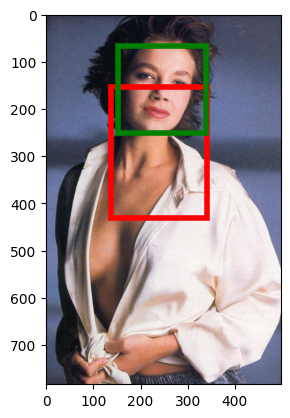

[378 118 691 431]
[tensor(358.7686), tensor(162.6113), tensor(708.8114), tensor(405.6121)]


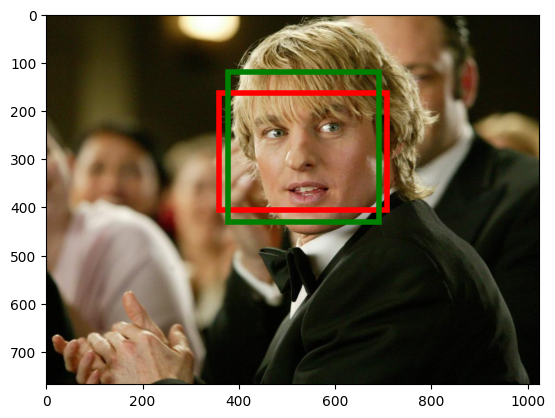

[ 96  18 199 121]
[tensor(100.9077), tensor(43.8766), tensor(199.3419), tensor(113.8731)]


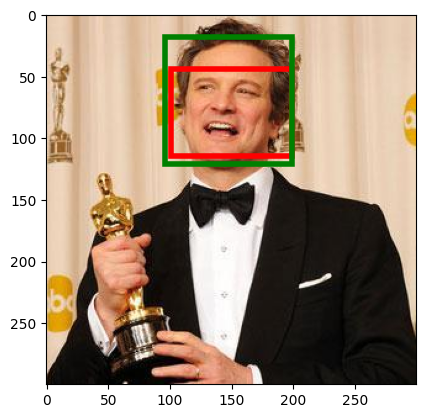

[218 303 548 633]
[tensor(173.8788), tensor(225.3628), tensor(480.5915), tensor(715.3045)]


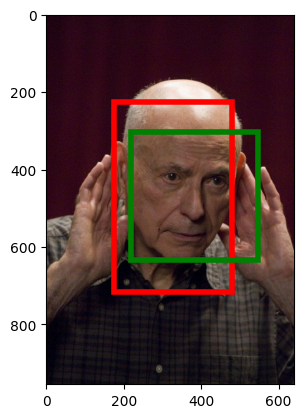

[218  88 352 222]
[tensor(247.4406), tensor(71.9261), tensor(507.0748), tensor(227.4664)]


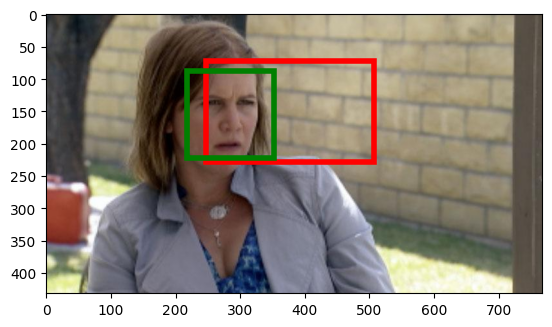

In [125]:
for image_name, target in test_data:
    with Image.open(images_path + image_name) as image:
        fig, ax = plt.subplots()
        ax.imshow(image)
        print(target)
        output = detection.predict(image)
        pred_fb = patches.Rectangle((output[0], output[1]), output[2]-output[0], output[3]-output[1], 
                               linewidth=4, edgecolor='red', facecolor='none')
        fb = patches.Rectangle((target[0], target[1]), target[2]-target[0], target[3]-target[1], 
                               linewidth=4, edgecolor='green', facecolor='none')
        ax.add_patch(pred_fb)
        ax.add_patch(fb)
        plt.show()

### Saving the model

In [132]:
detection_scripted = torch.jit.script(detection)
detection_scripted.save('detection_model.pt')

## The recognition model

In [127]:
# class RecognitionCNNModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()

# 2 linear layers
# va a sacar un vector y hacer argmax
# multimodal ??

In [128]:
# model = RecognitionCNNModel().to(device)
# print(model)

In [129]:
# torch.save(model, 'recognition_model.pth') # not model.state_dict() because we want to store the class also